In [1]:
import pandas as pd
from dateutil.parser import parse
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
prod = pd.read_csv('../Files/processed-data/prod_summ.csv').\
ix[:,["API","WELLID","FIRSTPRODDATE","LASTPRODDATE","CUMULATIVEOIL","FIRSTTWELVEMONTHOIL","FIRSTTWENTYFOURMONTHOIL"]]

well_header = pd.read_csv("../Files/processed-data/well_header.csv").\
ix[:,["WELLID","COUNTY","SURFACELATITUDE","SURFACELONGITUDE","WELLBOREPROFILE"]]

well_production = pd.merge(prod,well_header)
well_production.FIRSTPRODDATE = pd.to_datetime(well_production.FIRSTPRODDATE)
well_production.LASTPRODDATE = pd.to_datetime(well_production.LASTPRODDATE)
well_production['Start_Year'] = well_production.FIRSTPRODDATE.dt.year
well_production['End_Year'] = well_production.LASTPRODDATE.dt.year

active_wells = well_production[['WELLID', 'COUNTY', 'CUMULATIVEOIL','SURFACELATITUDE','SURFACELONGITUDE',\
                                'WELLBOREPROFILE', 'Start_Year', 'End_Year']]

for i in range(1978, 2016):
    active_wells[i] = list((active_wells['End_Year'] >= i) & (active_wells['Start_Year'] <= i))
    
# Active wells per year
by_welltype = active_wells.groupby('WELLBOREPROFILE').sum()
by_welltype = by_welltype.transpose()[6:]
    # Delete "Unkonw" column
by_welltype = by_welltype.drop('Unknown', 1)
by_welltype.columns = ['Directional', ' Horizontal', 'Vertical']

# Active wells per year by county
for_county = active_wells.ix[:, 8:]
for_county['WELLBOREPROFILE'] = active_wells['WELLBOREPROFILE']
for_county['COUNTY'] = active_wells['COUNTY']
wells_by_county = for_county.groupby(['WELLBOREPROFILE','COUNTY']).sum().unstack()
wells_by_county = wells_by_county.transpose()

C:\Users\Anirudh Narayanan\AppData\Local\Enthought\Canopy\User\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Anirudh Narayanan\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
# Combine with earthquake data - county level
earthquake = pd.read_csv('../Files/processed-data/completeEarthquakeFreq.csv', index_col=1, parse_dates = True)
earthquake.prefmag = pd.to_numeric(earthquake.prefmag)
earthquake['0-2'] = list(earthquake.prefmag <= 2)
earthquake['2-4'] = list((earthquake.prefmag > 2) & (earthquake.prefmag <=4))
earthquake['5-6'] = list((earthquake.prefmag > 4) & (earthquake.prefmag <=6))
earthquake['Count'] = 1
earthquake['Year'] = earthquake.index.year
earthquake = earthquake[earthquake['Year'] >= 1978]
earthquake_by_county = earthquake.groupby(['Year','county']).sum()
earthquake_by_county = earthquake_by_county.ix[:, 21:]

wells_by_county.index.names = ['Year', 'County']
earthquake_by_county.index.names = ['Year', 'County']
wells_and_earthquake = pd.merge(wells_by_county, earthquake_by_county, how = 'left', left_index=True, right_index=True)
wells_and_earthquake.corr()

WELLBOREPROFILE,DIRECTIONAL,HORIZONTAL,Unknown,VERTICAL,0-2,2-4,5-6,Count
WELLBOREPROFILE,,,,,,,,
DIRECTIONAL,1.000000,0.160958,-0.045053,0.111012,0.118344,0.006096,-0.004143,0.047515
HORIZONTAL,0.160958,1.000000,0.015929,0.004523,0.109311,0.195666,0.141305,0.191703
Unknown,-0.045053,0.015929,1.000000,0.125849,-0.030986,-0.023388,-0.021383,-0.029570
VERTICAL,0.111012,0.004523,0.125849,1.000000,-0.053545,-0.071511,-0.060616,-0.074982
0-2,0.118344,0.109311,-0.030986,-0.053545,1.000000,0.470219,0.408146,0.727075
2-4,0.006096,0.195666,-0.023388,-0.071511,0.470219,1.000000,0.804824,0.947804
5-6,-0.004143,0.141305,-0.021383,-0.060616,0.408146,0.804824,1.000000,0.774684
Count,0.047515,0.191703,-0.029570,-0.074982,0.727075,0.947804,0.774684,1.000000


In [12]:
# Combine with earthquake data - year level
earthquake_by_year = earthquake.groupby('Year').count()
earthquake_by_year = earthquake_by_year.ix[:, 30:]
earthquake_by_year = earthquake_by_year.drop(earthquake_by_year.index[[len(earthquake_by_year)-1]])
by_welltype.index.names = ['Year']
earthquake_by_year.index.names = ['Year']
earthquake_by_year.columns = ['0-2', '2-4', '4-6','Earthquake']
wells_and_earthquake_yearly = pd.merge(by_welltype, earthquake_by_year, how = 'left', left_index=True, right_index=True)

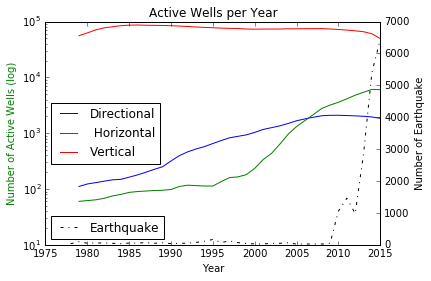

In [9]:
# Plot active wells per year
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(by_welltype)
ax1.set_yscale('log')
ax1.legend(by_welltype, loc = 'center left')
ax2.plot(earthquake_by_year['Earthquake'], 'k-.')
ax2.legend(loc = 'lower left')

ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Active Wells (log)', color='g')
ax2.set_ylabel('Number of Earthquake', color='k')
plt.title('Active Wells per Year')
plt.show()

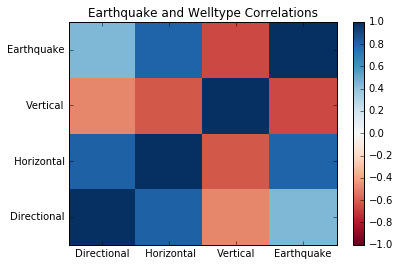

In [13]:
# Plot correlation matix
wells_and_earthquake_yearly = wells_and_earthquake_yearly.drop(['0-2','2-4','4-6'], 1)
corr = wells_and_earthquake_yearly.corr()
def plot_correlation(dataframe, title=''):
    lang_names = dataframe.columns.tolist()
    tick_indices = np.arange(0.5, len(lang_names) + 0.5)
    plt.figure()
    plt.pcolor(dataframe.values, cmap='RdBu', vmin=-1, vmax=1)
    colorbar = plt.colorbar()
    plt.title(title)
    plt.xticks(tick_indices, lang_names)
    plt.yticks(tick_indices, lang_names)
    
plot_correlation(corr, title='Earthquake and Welltype Correlations')
plt.savefig('../Plots/eq-welltype-corr.png')